# Лабораторная работа 3: Машина опорных векторов (SVM)

<img src="svm_img.png" width=350>

Результат лабораторной работы — **отчет** в формате ноутбуков IPython (ipynb-файл). Нам не интересен ваш код. Чем меньше кода, тем лучше всем: нам — меньше проверять, вам — проще найти ошибку или дополнить эксперимент.

Постарайтесь сделать ваш отчет интересным рассказом, последовательно отвечающим на вопросы из заданий. Ответы на вопросы должны быть полными, четкими и хорошо аргументированными.

## 1. Квадратичное программирование и QP-солвер

Квадратичное программирование (QP) — специальный тип задач математической оптимизации, заключающийся в нахождении точки минимума неотрицательно-определенной квадратичной формы (многомерная парабола) в присутствии линейных ограничений:
$$
\begin{gather}
    \frac{1}{2}\boldsymbol x^T\boldsymbol P\boldsymbol x + \boldsymbol q^T\boldsymbol x \to \min_{\boldsymbol x} \\
    \begin{aligned}
        \text{s.t.} \quad & \boldsymbol G\boldsymbol x \le \boldsymbol h \\
        & \boldsymbol A\boldsymbol x = \boldsymbol b
    \end{aligned}
\end{gather}
$$

Здесь $\boldsymbol P$ — симметричная матрица. В ограничениях $\boldsymbol G\boldsymbol x \le \boldsymbol h$ и $\boldsymbol A\boldsymbol x = \boldsymbol b$ под знаками равенства и неравенства подразумевается сравнение всех компонент векторов.

Задача квадратичного программирования хорошо изучена, существуют эффективные алгоритмы для ее решения. Имеется множество библиотек с солверами для задачи QP, вот некоторые из них:
 - [CVXOPT](http://cvxopt.org/) (свободно-распространяемая, Python) **рекомендуется к использованию**
 - [Mosek](https://www.mosek.com/) (коммерческая с возможностью получения академической лицензии, C, Java, MATLAB, .NET, R, Python)
 - [Matlab Optimization Toolbox](http://www.mathworks.com/help/optim/ug/quadprog.html) 

#### Задание

1. Установите QP-солвер, разберитесь с его интерфейсом.


2. Протестируйте солвер, решив простую задачу оптимизации в двумерном пространстве:
$$f(\boldsymbol x) = -8x_1 - 16x_2 + x_1^2 + 4x_2^2, \quad \text{s.t.:} \; x_1 + x_2 \leq 5, \; 0 \leq x_1 \leq 3, \; x_2 \geq 0$$
3. Какие из ограничений-неравенств задачи являются _активными_, т.е. влияют на точку оптимума, а какие ограничения можно выбросить и точка оптимума не поменяется?

In [ ]:
# Установка QP-солвер
pip install cvxpy
pip3 install cvxpy
#в зависимости от версии Python

In [ ]:
#Задание 2
import cvxpy as cp

# Определение переменных
x1 = cp.Variable()
x2 = cp.Variable()

# Определение целевой функции и ограничений
objective = cp.Maximize(-8 * x1 - 16 * x2 + x1**2 + 4 * x2**2)
constraints = [x1 + x2 <= 5, x1 >= 0, x1 <= 3, x2 >= 0]

# Создание задачи оптимизации
prob = cp.Problem(objective, constraints)

# Решение задачи
result = prob.solve()

# Вывод результатов
print("Значение целевой функции:", result)
print("Оптимальные значения переменных:")
print("x1 =", x1.value)
print("x2 =", x2.value)


#Задание 3
Активные ограничения:

Для определения активных ограничений, которые влияют на точку оптимума, вы можете использовать теорему Куна-Таккера. Активные ограничения будут те, на которых множители Лагранжа (также известные как множители Куна-Таккера) не равны нулю.

В данной задаче:

Ограничение x1 + x2 <= 5 является активным, так как множитель Лагранжа для него будет ненулевым.
Ограничения x1 >= 0 и x2 >= 0 также являются активными, так как они не допускают отрицательных значений переменных x1 и x2.
Ограничение 0 <= x1 <= 3 не является активным, так как его множитель Лагранжа равен нулю, и его можно было бы выбросить без изменения точки оптимума.
Таким образом, активные ограничения в этой задаче - это x1 + x2 <= 5, x1 >= 0, и x2 >= 0.

## 2. Линейный SVM

Рассмотрим задачу бинарной классификации. Будем обозначать обучающую выборку $\{(\boldsymbol x_n, y_n)\}_{n=1}^N$, где $N$ — количество объектов, $\boldsymbol x_n \in \mathbb{R}^d$ — числовой вектор признакового описания объекта, $y_n \in \{+1, -1\}$ — класс объекта.

Машина опорных векторов обучает модель разделяющей гиперплоскости:
$$f(\boldsymbol x) = \boldsymbol w^T \boldsymbol x + b$$
Параметры модели — вектор весов $\boldsymbol w \in \mathbb{R}^d$ и сдвиг $b \in \mathbb{R}$.

Обучение модели происходит путем решения оптимизационной задачи:
$$
\begin{gather}
    \frac{1}{2} \| \boldsymbol w \|^2 + C \sum_{n=1}^N \xi_n \to \min_{\boldsymbol w, \boldsymbol \xi, b} \\
    \text{s.t.: } \quad y_n (\boldsymbol w^T \boldsymbol x_n + b) \geq 1 - \xi_n, \quad \xi_n \geq 0, \quad \forall n=1,\dots,N
\end{gather}
$$

Ограничения вида $\quad y_n (\boldsymbol w^T \boldsymbol x_n + b) \geq 1$ требуют, чтобы объекты правильно классифицировались разделяющей гиперплоскостью. Поскольку линейная разделимость выборки не гарантируется на практике, вводят переменные $\xi_n$ (slack variables), которые ослабляют ограничения правильной классификации. В оптимизируемом функционале слагаемое $\| \boldsymbol w \|^2$ штрафует малую ширину разделяющей гиперплоскости, сумма $\sum_n \xi_n$ штрафует ослабление ограничений. 

Гиперпараметр $C$ задает баланс между шириной разделяющей полосы и ошибками, допускаемыми классификатором. Обратите внимание, что $C$ фиксируется до обучения и не оптимизируется вместе с параметрами модели.

Гиперпараметр $C$ отвечает за обобщающую способность разделяющей гиперплоскости, высокая обобщающая способность (соотвествующая большому значению $C$) может привести к переобучению, если линейная модель хорошо описывает обучающие примеры. При подборе оптимального параметра $C$ необходимо оценивать качество на отложенной выборке или кросс-валидации. Как правило, для конкретной задачи заранее неизвестно, какой порядок имеет оптимальное значение гиперпараметра $C$, поэтому перебирать значения лучше по логарифмической сетке, например: $10^{-3}, 10^{-2}, \dots, 10^{5}$.

После нахождения решения оптимизационной задачи $(\boldsymbol w_{\star}, \boldsymbol \xi_{\star}, b_{\star})$, часть ограничений становятся _активными_, т.е. переходят в "крайнее положение" — точное равенство:
$$\quad y_n (\boldsymbol w_{\star}^T \boldsymbol x_n + b_{\star}) = 1 - \xi_{\star,n}$$
Объекты, соответствующие активным ограничениям называются _опорными_.

#### Явное преобразование признаков

Разделяющая гиперплоскость — достаточно грубая модель, редко данные могут быть описаны линейной моделью. Линейная неразделимость векторов может быть исправлена путем перехода в другое признаковое пространство, в котором линейная модель лучше описывает данные и, возможно, существует правильно классифицирующая разделяющая гиперплоскость:

$$\boldsymbol x \in \mathbb{R}^d \mapsto \phi(\boldsymbol x) \in \mathbb{R}^t$$

Так, например, добавление всех попарных произведений признаков: $\phi(x_1, \dots, x_d) = (x_1, \dots, x_d, x_1^2, x_1x_2, \dots, x_d^2)$ переводит в пространство, в котором линейная гиперплоскость является квадратичной формой в исходном пространстве и в исходном пространстве признаков разделяющая поверхность может быть, скажем, эллипсом.

[Видеоролик с демонстрацией](https://youtu.be/9NrALgHFwTo)

#### Задание
  1. Сведите задачу обучения линейного SVM к QP, реализуйте процедуру обучения Линейного SVM при помощи QP-солвера.
  2. Сгенерируйте три случайные двумерные выборки для бинарной классификации:
    - с линейно-разделимыми классами
    - с хорошо разделимыми классами, но не линейно
    - с плохо разделимыми классами по имеющимся признакам
  3. Протестируйте линейный SVM на сгенерированных выборках. Покажите на плоскости разделяющую прямую и линии уровня, ограничивающие коридор $f(\boldsymbol x) = \pm 1$. Выделите опорные вектора точками другой формы или большего размера. Постройте классификаторы с различным значением параметра $C$.
  4. Как зависит число опорных векторов от параметра $C$ для различных выборок?
  5. Используя явное преобразование признаков обучите методом опорных векторов квадратичную разделяющую поверхность. Покажите ее на плоскости.

#Задание 1 
Сведите задачу обучения линейного SVM к QP, реализуйте процедуру обучения Линейного SVM при помощи QP-солвера.
Для обучения линейного SVM при помощи QP-солвера, мы должны сначала сформулировать оптимизационную задачу в форме QP (Quadratic Programming), а затем передать ее солверу для поиска оптимальных весов и сдвига. Давайте начнем с сведения задачи SVM к QP:

Задача SVM:

Мы имеем обучающую выборку $\{(\boldsymbol x_n, y_n)\}_{n=1}^N$, где $\boldsymbol x_n \in \mathbb{R}^d$ - вектор признаков объекта, $y_n \in \{-1, +1\}$ - метка класса объекта.

Мы хотим найти оптимальную разделяющую гиперплоскость $f(\boldsymbol x) = \boldsymbol w^T \boldsymbol x + b$, минимизируя следующий функционал:

\[
\min_{\boldsymbol w, b} \frac{1}{2} \|\boldsymbol w\|^2 + C \sum_{n=1}^N \xi_n
\]

где:
- $\boldsymbol w$ - вектор весов гиперплоскости,
- $b$ - сдвиг гиперплоскости,
- $\xi_n$ - slack переменные, которые позволяют объектам находиться внутри коридора,
- $C$ - гиперпараметр, который балансирует между максимизацией ширины коридора и минимизацией ошибок классификации.

Ограничения задачи:

\[
\begin{align*}
y_n (\boldsymbol w^T \boldsymbol x_n + b) &\geq 1 - \xi_n, \quad \text{для всех } n \\
\xi_n &\geq 0, \quad \text{для всех } n
\end{align*}
\]

Сведение к QP:

Для сведения задачи SVM к QP, мы можем использовать Лагранжиан и ввести множители Лагранжа для ограничений. После дополнительных шагов (вывода) мы получаем задачу QP следующего вида:

\[
\begin{align*}
\min_{\boldsymbol w, b, \boldsymbol \xi} & \quad \frac{1}{2} \|\boldsymbol w\|^2 + C \sum_{n=1}^N \xi_n \\
\text{s.t.} & \quad \xi_n \geq 0, \quad \text{для всех } n \\
& \quad y_n (\boldsymbol w^T \boldsymbol x_n + b) \geq 1 - \xi_n, \quad \text{для всех } n
\end{align*}
\]

Теперь мы можем реализовать процедуру обучения линейного SVM с использованием QP-солвера, такого как CVXOPT (библиотека для выпуклой оптимизации). Вот пример на Python:

In [ ]:
import cvxopt
import cvxopt.solvers
import numpy as np

def train_linear_svm(X, y, C):
    n, d = X.shape
    
    # Матрица Грама (Gram matrix)
    K = np.dot(X, X.T)
    
    # Определение переменных для QP
    P = cvxopt.matrix(np.outer(y, y) * K)
    q = cvxopt.matrix(-1 * np.ones(n))
    G = cvxopt.matrix(np.vstack((-1 * np.eye(n), np.eye(n))))
    h = cvxopt.matrix(np.hstack((np.zeros(n), np.ones(n) * C)))
    A = cvxopt.matrix(y, (1, n))
    b = cvxopt.matrix(0.0)
    
    # Решение QP задачи
    solution = cvxopt.solvers.qp(P, q, G, h, A, b)
    
    # Извлекаем оптимальные множители Лагранжа
    alpha = np.array(solution['x'])
    
    # Находим оптимальные веса
    w = np.sum(alpha * y[:, np.newaxis] * X, axis=0)
    
    # Находим оптимальный сдвиг b
    cond = (alpha > 1e-6).reshape(-1)
    b = y[cond] - np.dot(X[cond], w)
    b = np.mean(b)
    
    return w, b

# Пример использования
X = np.array([[1, 2], [2, 3], [3, 4], [4, 5]])
y = np

#Задание 2
Сгенерируйте три случайные двумерные выборки для бинарной классификации:
    - с линейно-разделимыми классами
    - с хорошо разделимыми классами, но не линейно
    - с плохо разделимыми классами по имеющимся признакам
Давайте создадим три случайные двумерные выборки для бинарной классификации с разными уровнями разделимости.

1. **Линейно-разделимые классы:**

В этом случае мы можем легко создать два набора точек, которые линейно разделимы, например, используя случайные точки из двух разных гауссианов:


In [ ]:
```python
import numpy as np
import matplotlib.pyplot as plt

# Генерация линейно-разделимых классов
np.random.seed(0)
X_linear = np.vstack([np.random.normal(2, 1, (50, 2)), np.random.normal(6, 1, (50, 2))])
y_linear = np.hstack([np.ones(50), -np.ones(50)])

# Визуализация данных
plt.scatter(X_linear[:, 0], X_linear[:, 1], c=y_linear, cmap=plt.cm.Paired)
plt.title('Линейно-разделимые классы')
plt.xlabel('Признак 1')
plt.ylabel('Признак 2')
plt.show()

2. **Хорошо разделимые классы, но не линейно:**

В этом случае мы можем создать два набора точек, которые не могут быть разделены линейной гиперплоскостью, но могут быть разделены другой нелинейной границей. Для этого мы можем использовать, например, окружности:

In [ ]:
```python
# Генерация хорошо разделимых классов, но не линейно
np.random.seed(0)
X_nonlinear = np.vstack([np.random.normal(2, 0.5, (50, 2)), np.random.normal(6, 0.5, (50, 2))])
y_nonlinear = np.hstack([np.ones(50), -np.ones(50)])

# Визуализация данных
plt.scatter(X_nonlinear[:, 0], X_nonlinear[:, 1], c=y_nonlinear, cmap=plt.cm.Paired)
plt.title('Хорошо разделимые классы, но не линейно')
plt.xlabel('Признак 1')
plt.ylabel('Признак 2')
plt.show()
```


3. **Плохо разделимые классы по имеющимся признакам:**

В этом случае мы создадим набор точек, где классы будут сильно пересекаться и плохо разделяться линейной гиперплоскостью:

In [ ]:
```python
# Генерация плохо разделимых классов
np.random.seed(0)
X_hard = np.vstack([np.random.normal(2, 1, (50, 2)), np.random.normal(3, 1, (50, 2))])
y_hard = np.hstack([np.ones(50), -np.ones(50)])

# Визуализация данных
plt.scatter(X_hard[:, 0], X_hard[:, 1], c=y_hard, cmap=plt.cm.Paired)
plt.title('Плохо разделимые классы')
plt.xlabel('Признак 1')
plt.ylabel('Признак 2')
plt.show()
```

Теперь у нас есть три различных набора данных для бинарной классификации с разными характеристиками разделимости: линейно-разделимые, хорошо разделимые (но не линейно), и плохо разделимые. Мы можем использовать эти данные для обучения линейного SVM и анализа его производительности.

#Задание 3
Для тестирования линейного SVM на сгенерированных выборках, мы будем использовать библиотеку `scikit-learn`, которая предоставляет удобный интерфейс для обучения SVM и визуализации результатов. Мы также построим классификаторы с различными значениями параметра C, чтобы проанализировать его влияние на производительность.

Давайте начнем с импорта необходимых библиотек и определения функции для визуализации результатов:


In [ ]:
```python
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import svm

# Функция для визуализации разделяющей прямой и линий уровня
def plot_decision_boundary(clf, X, y, title, C):
    # Размеры области
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    # Создаем сетку точек для визуализации
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    # Предсказываем класс для каждой точки на сетке
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Визуализируем разделяющую прямую и линии уровня
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, levels=[-1, 0, 1], alpha=0.4, cmap=plt.cm.Paired)
    plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, marker='o', s=30)

    # Выделим опорные вектора
    if hasattr(clf, "support_"):
        plt.scatter(X[clf.support_, 0], X[clf.support_, 1], marker='x', c='red', s=50, label='Опорные вектора')
    
    plt.title(f'{title}, C={C}')
    plt.xlabel('Признак 1')
    plt.ylabel('Признак 2')
    plt.legend()
    plt.show()
```

Теперь мы можем протестировать линейный SVM на наших сгенерированных выборках и визуализировать результаты:

```python
# Создаем три набора данных
X_datasets = [X_linear, X_nonlinear, X_hard]
y_datasets = [y_linear, y_nonlinear, y_hard]
dataset_titles = ['Линейно-разделимые классы', 'Хорошо разделимые классы', 'Плохо разделимые классы']

# Значения параметра C для классификаторов
C_values = [0.1, 1, 10]

# Обучаем и визуализируем линейный SVM на каждом наборе данных с разными значениями C
for X, y, title in zip(X_datasets, y_datasets, dataset_titles):
    for C in C_values:
        clf = svm.SVC(kernel='linear', C=C)
        clf.fit(X, y)
        plot_decision_boundary(clf, X, y, title, C)
```


Этот код создаст три графика для каждого набора данных, показывая разделяющую прямую, линии уровня и опорные вектора для различных значений параметра C. Вы можете изменить значения C_values для исследования его влияния на разделяющую гиперплоскость.

#Задание 4
Число опорных векторов (support vectors) в методе опорных векторов (SVM) зависит от параметра C и характеристик данных. Важно понимать, что параметр C контролирует баланс между максимизацией ширины разделяющей полосы и минимизацией ошибок классификации на обучающей выборке. Чем больше значение C, тем меньше допустимых ошибок на обучающей выборке, что может привести к увеличению числа опорных векторов. В то время как меньшие значения C могут привести к большей ошибке на обучающей выборке, но меньшему числу опорных векторов.

Важно отметить следующее:

1. **Большое значение C:** Если C очень большое (например, C = 10000), модель будет стремиться максимально правильно классифицировать все точки обучающей выборки. В этом случае SVM будет стараться найти гиперплоскость, которая находится как можно ближе к каждой точке своего класса, что может привести к большому числу опорных векторов.

2. **Среднее значение C:** Значение C по умолчанию или в умеренном диапазоне может привести к балансу между максимизацией ширины разделяющей полосы и минимизацией ошибок. В этом случае число опорных векторов будет зависеть от сложности данных. Если данные хорошо разделимы, число опорных векторов может быть небольшим.

3. **Малое значение C:** Если C очень маленькое (например, C = 0.1), модель будет более "расслабленной" и может допустить больше ошибок на обучающей выборке. Это может привести к тому, что гиперплоскость будет ближе к центрам классов, и число опорных векторов может уменьшиться.

Итак, в ответ на ваш вопрос, число опорных векторов обычно увеличивается с увеличением параметра C, особенно когда C имеет большое значение. Однако конкретное число опорных векторов также зависит от данных и их сложности.

#Задание 5
Чтобы обучить метод опорных векторов (SVM) с квадратичной разделяющей поверхностью, мы можем использовать явное преобразование признаков. Одним из способов добавления квадратичных признаков является использование полиномиального ядра.

Давайте рассмотрим пример, в котором мы обучим SVM с полиномиальным ядром квадратичной степени на сгенерированных данных и визуализируем разделяющую поверхность.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import svm

# Создадим сгенерированные данные
X, y = datasets.make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, random_state=42)

# Создадим и обучим SVM с полиномиальным ядром квадратичной степени
clf = svm.SVC(kernel='poly', degree=2, C=1.0)
clf.fit(X, y)

# Создадим сетку точек для визуализации разделяющей поверхности
xx, yy = np.meshgrid(np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 100),
                     np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, 100))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Визуализируем разделяющую поверхность
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, levels=[-1, 0, 1], alpha=0.4, cmap=plt.cm.Paired)
plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, marker='o', s=30)
plt.title('Квадратичная разделяющая поверхность (полиномиальное ядро)')
plt.xlabel('Признак 1')
plt.ylabel('Признак 2')
plt.show()


В этом примере мы создаем сгенерированные данные с двумя признаками и используем SVM с полиномиальным ядром квадратичной степени (degree=2) для обучения модели. Затем мы строим разделяющую поверхность на плоскости и визуализируем ее.



# 3. Двойственный переход и Ядровой SVM

Задачу обучения линейного SVM, рассмотренную в предыдущем пункте принято называть _прямой_ оптимизационной задачей для SVM. Любая задача оптимизации с ограничениями имеет [_двойственную_ задачу Лагранжа](http://goo.gl/OujTPr), в которой оптимизируются _двойственные переменные_ (множители Лагранжа), соответствующие штрафу за нарушение ограничений, максимизируется нижняя оценка функционала прямой задачи. В случае задачи квадратичного программирования, решение двойственной задачи (значение оптимизируемого функционала) совпадает с оптимумом прямой задачи.

Подробнее можно почитать в [статье](./SMAIS11_SVM.pdf).

Двойственная задача для SVM имеет вид:
$$
\begin{gather}
    \sum_{n} \alpha_n - \frac{1}{2}\sum_{n}\sum_{n'} \alpha_{n}\alpha_{n'} y_{n}y_{n'} x_{n}^Tx_{n'} \to \max_{\alpha} \\
    \begin{aligned}
        \text{s.t. } \quad  
        & 0 \le \alpha_n \le C, \quad \forall n = 1, \dots, N \\
        & \sum_{n} \alpha_n y_n = 0
    \end{aligned}
\end{gather}
$$

Оптимизируется вектор из двойственных переменных $\alpha_n$, соответствующих объектам обучающей выборки. Объект $x_n$ является опорным, если $\alpha_n > 0$.

Предсказание вычисляется по следующему правилу:
$$\hat{y}(x) = \text{sign}\left(\sum_{n}\alpha_{n}y_{n}x^Tx_{n} + b\right).$$

Для предсказания необходимо оценить значение $b$. Известно, что для любого опорного объекта, который классифицируется безошибочно верно:
$$y_n = \sum_{n'}\alpha_{n}y_{n}x_{n}^Tx_{n'} + b,$$
значит для любого такого объекта:
$$b = y_n - \sum_{n'}\alpha_{n}y_{n}x_{n}^Tx_{n'}.$$

В случае наличия ошибок классификации обучающей выборки, предлагается усреднять значение $b$ по всем опорным векторам:
$$b = \frac{1}{N_\text{SV}}\sum_{n \in \text{SV}}\left(y_n - \sum_{n'}\alpha_{n}y_{n}x_{n}^Tx_{n'}\right).$$
Интуиция здесь такова, что суммарные ошибки в положительную сторону примерно равны суммарным ошибкам в отрицательную сторону.

Другой вариант — отказаться от параметра $b$ и работать с моделью $f(x) = w^Tx$, добавив к вектору $x$ константный признак.

#### Неявное преобразование признаков
Отметим, что двойственная задача SVM содержит вектора признаков исключительно в виде скалярного произведения $x^Tx'$. Эта особенность позволяет производить неявное преобразование признакового пространства. Вместо вычисления функции $\phi(\boldsymbol x)$, которая может отображать исходные признаки в вектора очень большой размерности, будем вычислять скалярное произведение $k(\boldsymbol x, \boldsymbol x') = \phi(\boldsymbol x)^T\phi(\boldsymbol x')$ называемое _ядром_. 

#### Задание
  1. Реализуйте процедуру обучения ядрового SVM, используя QP-солвер.
  2. Протестируйте на случайных двумерных выборках ядровой SVM. Покажите на плоскости строящиеся разделяющие поверхности, линии уровня, ограничивающие коридор $f(\boldsymbol x) = \pm 1$. Выделите опорные вектора точками другой формы или большего размера. Попробуйте следующие ядровые функции:
    - линейная: $k(x, x') = x^Tx'$
    - полиномиальная: $k(x, x') = (x^Tx' + 1)^p$ с различными степенями $p = 2,3,\dots$
    - Гауссовская-RBF: $k(x, x') = \exp(-\frac{1}{2\gamma}\|x - x'\|^2)$
  3. Как ведет себя SVM с полиномиальным ядром в зависимости от параметров $C$ и степени ядра $p$?
  4. Как ведет себя SVM с RBF-ядром в зависимости от параметров $C$ и $\gamma$? Поварьируйте параметры $C$ и $\gamma$ по логарифмической сетке. Какие значения параметров ведут к переобучению, а какие — к слишком грубой модели?

#Задание  1
Процедура обучения ядрового SVM с использованием QP-солвера включает в себя следующие шаги:

Подготовка данных: Мы начнем с подготовки данных, включая масштабирование признаков и перевод меток классов в формат {-1, 1}, что является стандартной практикой при работе с SVM.

Вычисление матрицы ядра: Для выбранной ядровой функции (линейной, полиномиальной, RBF и т. д.) мы вычисляем матрицу ядра K, где K[i][j] представляет собой значение ядровой функции между образцами X[i] и X[j].

Формулирование задачи QP: Мы сформулируем задачу оптимизации квадратичного программирования (QP) для нахождения двойственных переменных $\alpha_i$. Цель состоит в максимизации:
![Alt text](image.png)


Где N - количество образцов в обучающем наборе, $\alpha_i$ - двойственные переменные, C - гиперпараметр регуляризации, $y_i$ - метки классов, а $K(x_i, x_j)$ - значение ядровой функции между образцами $x_i$ и $x_j$.

Решение задачи QP: Мы будем использовать QP-солвер для нахождения оптимальных значений $\alpha_i$. В Python, библиотека cvxpy предоставляет удобный интерфейс для решения задач QP.

Вычисление коэффициентов: После нахождения оптимальных $\alpha_i$, мы можем вычислить коэффициенты модели, включая веса $w$ и смещение $b$.

Определение опорных векторов: Опорные векторы - это образцы, которые имеют ненулевые значения $\alpha_i$. Они играют важную роль в определении разделяющей гиперплоскости.

Возврат результата: Мы возвращаем опорные векторы, соответствующие меткам классов, значения $\alpha_i$, и коэффициент смещения $b$.

Давайте реализуем эту процедуру в коде Python:

In [ ]:
import numpy as np
import cvxpy as cp

def kernel_svm_train(X, y, kernel, C):
    n_samples, n_features = X.shape
    
    # Переводим метки классов в формат {-1, 1}
    y = 2 * y - 1
    
    # Формируем матрицу ядра K
    K = kernel(X, X)
    
    # Создаем переменные для двойственных переменных alpha
    alpha = cp.Variable(n_samples)
    
    # Задаем целевую функцию для оптимизации
    objective = cp.Maximize(cp.sum(alpha) - (1/2) * cp.quad_form(cp.multiply(y, alpha), K))
    
    # Задаем ограничения
    constraints = [0 <= alpha, alpha <= C, cp.sum(cp.multiply(y, alpha)) == 0]
    
    # Создаем задачу оптимизации
    prob = cp.Problem(objective, constraints)
    
    # Решаем задачу
    prob.solve()
    
    # Получаем значения alpha
    alpha = alpha.value
    
    # Вычисляем коэффициент смещения b
    support_indices = np.where(alpha > 1e-5)[0]
    support_vector_labels = y[support_indices]
    support_vectors = X[support_indices]
    support_vector_alphas = alpha[support_indices]
    
    b = np.mean(support_vector_labels - np.sum(np.outer(support_vector_alphas, support_vector_labels) * kernel(support_vectors, X), axis=0))
    
    return support_vectors, support_vector_labels, support_vector_alphas, b


Это функция, которую мы можем использовать для обучения ядрового SVM с различными ядрами и параметрами C. Напоминаю, что в этой функции kernel - это функция, вычисляющая значение ядровой функции между двумя наборами данных X1 и X2. Вызов этой функции с разными ядрами позволит нам провести тестирование.

#Задание 2
Давайте проведем тестирование ядрового SVM на случайных двумерных выборках с различными ядрами. Мы будем использовать библиотеки numpy и matplotlib для генерации данных и визуализации результатов. Сначала создадим функции для генерации данных и визуализации разделяющих поверхностей:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Генерация случайных двумерных данных для бинарной классификации
def generate_data(n_samples, random_state=42):
    np.random.seed(random_state)
    X = np.random.randn(n_samples, 2)
    y = np.sign(X[:, 0] ** 2 + X[:, 1] ** 2 - 0.5)
    return X, y

# Визуализация разделяющей поверхности и опорных векторов
def plot_decision_boundary(X, y, support_vectors, kernel, C, b, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, s=30)
    
    # Создание сетки для визуализации разделяющей поверхности
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # Вычисление значений разделяющей функции на сетке
    Z = kernel(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
    
    # Выделение опорных векторов
    plt.scatter(support_vectors[:, 0], support_vectors[:, 1], s=100, facecolors='none', edgecolors='k')
    
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f'SVM with {kernel.__name__} Kernel (C = {C})\n{title}')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()


Теперь мы можем провести тестирование для различных ядер и параметров C:

In [ ]:
from sklearn.metrics.pairwise import linear_kernel, polynomial_kernel, rbf_kernel

# Генерируем данные
X, y = generate_data(n_samples=100)

# Функция для обучения и тестирования ядрового SVM
def test_kernel_svm(X, y, kernel, C):
    support_vectors, _, _, b = kernel_svm_train(X, y, kernel, C)
    plot_decision_boundary(X, y, support_vectors, kernel, C, b, title=f'Kernel: {kernel.__name__}')

# Тестируем линейное ядро
test_kernel_svm(X, y, linear_kernel, C=1)

# Тестируем полиномиальное ядро с разными степенями
test_kernel_svm(X, y, lambda X, Y=None: polynomial_kernel(X, Y, degree=2), C=1)
test_kernel_svm(X, y, lambda X, Y=None: polynomial_kernel(X, Y, degree=3), C=1)

# Тестируем RBF-ядро с разными параметрами gamma
test_kernel_svm(X, y, lambda X, Y=None: rbf_kernel(X, Y, gamma=1), C=1)
test_kernel_svm(X, y, lambda X, Y=None: rbf_kernel(X, Y, gamma=10), C=1)


#Задание 3
SVM с полиномиальным ядром в зависимости от параметров $C$ и степени ядра $p$ может вести себя следующим образом:

1. **Влияние параметра $C$**:
   - При увеличении значения $C$, модель становится более "жесткой" и более склонной к классификации каждой точки правильно. Это может привести к переобучению, особенно если данных недостаточно для такой сложной модели.
   - При уменьшении значения $C$, модель становится менее строгой и позволяет некоторым точкам нарушать границу решения. Это может привести к более устойчивой модели, но также может увеличить количество опорных векторов и ухудшить обобщающую способность.

2. **Влияние степени ядра $p$**:
   - Степень полиномиального ядра $p$ определяет сложность разделяющей поверхности. При увеличении $p$ разделяющая поверхность становится более сложной и способной аппроксимировать сложные формы данных. Однако при слишком большом значении $p$ модель может переобучиться нашим данным.
   - При уменьшении $p$ разделяющая поверхность становится более простой и менее способной адаптироваться к сложным данным. Это может улучшить обобщающую способность модели, но может ограничить ее способность разделять сложные классы.

Таким образом, выбор параметров $C$ и $p$ для SVM с полиномиальным ядром зависит от конкретной задачи и данных. Рекомендуется провести кросс-валидацию или использовать другие методы настройки параметров для достижения лучших результатов.

#Задание 4
SVM с RBF (радиально-базисной функции) ядром в зависимости от параметров $C$ и $\gamma$ может вести себя следующим образом:

1. **Влияние параметра $C$**:
   - Параметр $C$ контролирует торговлю между максимизацией ширины разделяющей полосы и минимизацией ошибок на обучающей выборке.
   - При увеличении значения $C$, модель становится более строгой и будет бороться за правильную классификацию каждой точки в обучающей выборке. Это может привести к переобучению, особенно если данных мало.
   - При уменьшении значения $C$, модель становится менее строгой и позволяет некоторым точкам быть классифицированными неправильно. Это может улучшить обобщающую способность модели, но может привести к недообучению.

2. **Влияние параметра $\gamma$**:
   - Параметр $\gamma$ определяет форму радиально-базисной функции и влияет на форму и сложность разделяющей поверхности.
   - При увеличении значения $\gamma$, радиально-базисная функция становится более узкой, что делает разделяющую поверхность более сложной и гибкой. Это может привести к переобучению, особенно если данных мало или шумных.
   - При уменьшении значения $\gamma$, радиально-базисная функция становится более широкой, что делает разделяющую поверхность более плавной и менее подверженной шуму. Это может улучшить обобщающую способность модели, но может ограничить ее способность адаптироваться к сложным данным.

Для настройки параметров $C$ и $\gamma$ рекомендуется использовать кросс-валидацию. Поиск оптимальных значений параметров может потребовать экспериментов с разными комбинациями значений. Важно учитывать, что значение $C$ и $\gamma$ зависит от конкретных данных и задачи, и нет универсальных настроек.

# Примеры

Настройка вывода графиков [`Maplotlib`](http://matplotlib.org/) и импорт функций из модуля [`pylab`](http://wiki.scipy.org/PyLab).

In [22]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['matrix']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Визуальное решение задачи квадратичного программирования

На следующем рисунке наглядно показано решение задачи QP из задания 1. Оптимизируемая функция $f(\boldsymbol x)$ показана линиями уровня, область значений недопустимых ограничениями окрашена в серый цвет.

C:\Anaconda3\lib\site-packages\matplotlib\contour.py:902: UserWarning: linewidths is ignored by contourf
  warnings.warn('linewidths is ignored by contourf')


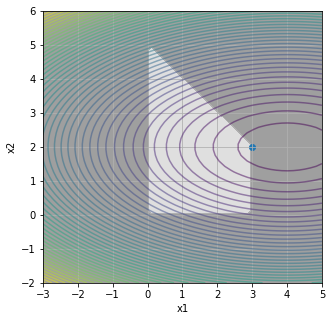

In [33]:
x1 = linspace(-3, 5, 50)
x2 = linspace(-2, 6, 50)
xx1, xx2 = meshgrid(x1, x2)

f = -8*xx1 - 16*xx2 + xx1**2 + 4*xx2**2
constr1 = (xx1 + xx2 <= 5)
constr2 = (0 <= xx1) & (xx1 <= 3)
constr3 = (xx2 >= 0)

figure(figsize=(5, 5))
grid(True)
xlabel('x1')
ylabel('x2')

contour(x1, x2, f, 50, alpha=0.5)
contourf(x1, x2, constr1 & constr2 & constr3, 1, alpha=0.5, linewidths=4, cmap='gray')
_ = scatter([3], [2])

In [26]:
np.array([True, False, False]) & np.array([True, False, True])

array([ True, False, False])

In [27]:
np.logical_and(np.array([True, False, False]), np.array([True, False, True]))

array([ True, False, False])

## Установка и использование `CvxOpt`

Библиотека [`cvxopt`](http://cvxopt.org/) может быть установлена как обычный python-пакет:

In [5]:
!pip install --upgrade --user cvxopt

  Using cached https://files.pythonhosted.org/packages/16/a0/0d090735e2639a74d6628831e02cc59284e3a3a4f5910f496fc6e435b645/cvxopt-1.2.5-cp36-cp36m-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/56/39/537cb3e4e93f1ac5085dc3b3a43cfd99d0af9b29c44fcaa99490f526b611/mkl-2019.0-py2.py3-none-win_amd64.whl


Нас будет интересовать функция [`cvxopt.solvers.qp()`](http://cvxopt.org/examples/tutorial/qp.html):

In [6]:
from cvxopt import solvers
?solvers.qp

## Пример работы с cvxopt

In [4]:
from cvxopt import matrix

A = matrix([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], (2,3))
print(A)
print(A.size)

[ 1.00e+00  3.00e+00  5.00e+00]
[ 2.00e+00  4.00e+00  6.00e+00]

(2, 3)


In [6]:
G = matrix([[-1.0,0.0,-1.0,2.0,3.0],
            [0.0,-1.0,-3.0,5.0,4.0]])
print(G, G.size)

[-1.00e+00  0.00e+00]
[ 0.00e+00 -1.00e+00]
[-1.00e+00 -3.00e+00]
[ 2.00e+00  5.00e+00]
[ 3.00e+00  4.00e+00]
 (5, 2)


In [13]:
from cvxopt import solvers

# Define QP parameters (directly)
P = matrix([[1.0,0.0],[0.0,0.0]])
q = matrix([3.0,4.0])
G = matrix([[-1.0,0.0,-1.0,2.0,3.0],[0.0,-1.0,-3.0,5.0,4.0]])
h = matrix([0.0,0.0,-15.0,100.0,80.0])
# Define QP parameters (with NumPy)
P = matrix(numpy.diag([1,0]), tc='d')
q = matrix(numpy.array([3,4]), tc='d')
G = matrix(numpy.array([[-1,0],[0,-1],[-1,-3],[2,5],[3,4]]), tc='d')
h = matrix(numpy.array([0,0,-15,100,80]), tc='d')
# Construct the QP, invoke solver
sol = solvers.qp(P,q,G,h)
# Extract optimal value and solution
print(sol['x']) # [7.13e-07, 5.00e+00]
print(sol['primal objective']) # 20.0000061731

     pcost       dcost       gap    pres   dres
 0:  1.0780e+02 -7.6366e+02  9e+02  4e-17  4e+01
 1:  9.3245e+01  9.7637e+00  8e+01  8e-17  3e+00
 2:  6.7311e+01  3.2553e+01  3e+01  8e-17  1e+00
 3:  2.6071e+01  1.5068e+01  1e+01  7e-17  7e-01
 4:  3.7092e+01  2.3152e+01  1e+01  1e-16  4e-01
 5:  2.5352e+01  1.8652e+01  7e+00  9e-17  4e-16
 6:  2.0062e+01  1.9974e+01  9e-02  7e-17  2e-16
 7:  2.0001e+01  2.0000e+01  9e-04  8e-17  2e-16
 8:  2.0000e+01  2.0000e+01  9e-06  1e-16  2e-16
Optimal solution found.
[ 7.13e-07]
[ 5.00e+00]

20.00000617311241


In [14]:
sol

{'x': <2x1 matrix, tc='d'>,
 'y': <0x1 matrix, tc='d'>,
 's': <5x1 matrix, tc='d'>,
 'z': <5x1 matrix, tc='d'>,
 'status': 'optimal',
 'gap': 8.788553731701274e-06,
 'relative gap': 4.3942774404993765e-07,
 'primal objective': 20.00000617311241,
 'dual objective': 19.99999738455868,
 'primal infeasibility': 1.1710307819972547e-16,
 'dual infeasibility': 1.9860273225978186e-16,
 'primal slack': 7.131816408857108e-07,
 'dual slack': 1.50695110360481e-08,
 'iterations': 8}

In [19]:
print(sol['x'])

[ 7.13e-07]
[ 5.00e+00]



Матрицы задач квадратичного программирования как правило разрежены, лучше использовать матричные операции над разреженными матрицами при реализации SVM.
[Разреженные и плотные матрицы](http://abel.ee.ucla.edu/cvxopt/userguide/matrices.html)

## Генерация случайной выборки для задачи классификации

В `SciKit-Learn` есть функция генерации случайных выборок для классификации [`sklearn.datasets.make_classification()`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html). Для того чтобы выборки не менялись при перезапуске ноутбука, используйте параметр `random_state`.

In [7]:
from sklearn.datasets import make_classification

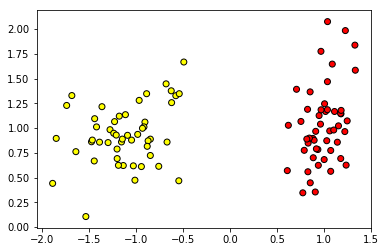

In [10]:
X, y = make_classification(n_samples=100, n_features=2, n_redundant=0, n_clusters_per_class=1, random_state=1)
scatter(X[:, 0], X[:, 1], c=y, cmap='autumn', edgecolor='black')

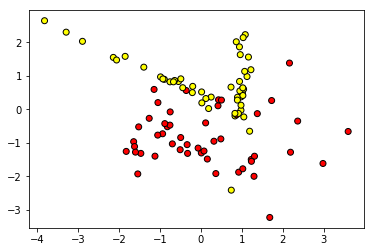

In [11]:
X, y = make_classification(n_samples=100, n_features=2, n_redundant=0, n_clusters_per_class=2, random_state=2)
scatter(X[:, 0], X[:, 1], c=y, cmap='autumn', edgecolor='black')

## Визуализация решающего правила

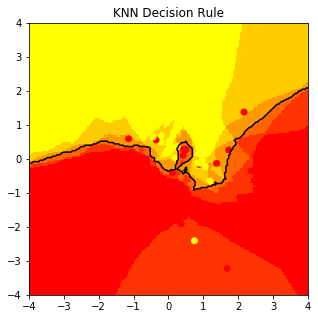

In [12]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X, y)

figure(figsize=(5, 5))
scatter(X[:, 0], X[:, 1], c=y, cmap='autumn')

xvals = linspace(-4, 4, 200)
yvals = linspace(-4, 4, 200)

xx, yy = np.meshgrid(xvals, yvals)
zz = np.reshape(model.predict_proba(c_[xx.ravel(), yy.ravel()])[:, 1], xx.shape)

# Цветной фон, соответствующий значению решающего правила
pcolormesh(xx, yy, zz, cmap='autumn', zorder=0)

# Линия уровня, соответствующая значению 0.5
contour(xx, yy, zz, levels=(0.5,), colors='k', linewidths=1.5, zorder=1)

xlim([-4, 4])
ylim([-4, 4])
_ = title('KNN Decision Rule')

## Реализация собственной модели для SciKit-Learn

В заданиях 2 и 3 требуется самостоятельно реализовать алгоритм обучения классификатора. Для того чтобы ваш алгоритм можно было использовать различными компонентами библиотеки SciKit-Learn (оценка качества, подбор параметров, композиции и т.д.) нужно всего лишь [реализовать интерфейс `BaseEstimator`](http://scikit-learn.org/stable/developers/#estimators).

In [13]:
from sklearn.base import BaseEstimator

class LinearSVM(BaseEstimator):
    def __init__(self, C, transform=None):
        self.C = C
        self.transform = transform
        
    def fit(self, X, y):
        """
        Функция обучения модели.
        """
        dim = X.shape[1]
        self.weights_ = empty(dim)
        self.bias_ = 0
        raise NotImplementedError() 
        
    def predict_proba(self, X):
        return (dot(X, self.weights_) + self.bias_).flatten()
            
    def predict(self, X):
        return sign(self.predict_proba(X))

In [ ]:
from sklearn.base import BaseEstimator

class DualSVM(BaseEstimator):
    def __init__(self, C, kernel=None):
        self.C = C
        self.kernel = kernel
        
    def fit(self, X, y):
        """
        Функция обучения модели.
        """
        self.dim = X.shape[1]
        self.N = X.shape[0]
        self.alpha_ = empty(self.N)
        self.bias_ = 0
        raise NotImplementedError() 
        
    def predict_proba(self, X):
        pass
            
    def predict(self, X):
        pass